## Segmentation for porous media images

__Authors__: Masa Prodanovic and Bernard Chang, The University of Texas at Austin

__Last update__: Dec 2024


In [16]:
#import relavant libraries and functions
try:
    import dpm_tools
    assert dpm_tools.__version__ >= "0.0.4"
except ModuleNotFoundError:
    !pip install --user -r ../requirements.txt
except AssertionError:
    !pip install --upgrade dpm_tools --user

import matplotlib.pyplot as plt
import numpy as np

import skimage
import skimage.filters as sf
import skimage.morphology as sm

from skimage import io, img_as_float, img_as_ubyte
from skimage import exposure
from skimage.filters import threshold_mean, threshold_multiotsu, threshold_otsu
from skimage.filters import try_all_threshold

from skimage.morphology import (erosion, dilation, opening, closing,  white_tophat)
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk

import tifffile as tf

import dpm_tools
from dpm_tools.metrics import histogram_statistics as hist_stats
from dpm_tools.segmentation import statistical_region_merging as srm

!pip install --user --use-pep517 medpy
from medpy.filter.smoothing import anisotropic_diffusion


In [7]:
# UTILITY FUNCTIONS

def plot_comparison(original, original_name, filtered, filter_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 8), sharex=True, sharey=True)
    ax1.imshow(original)
    ax1.set_title(original_name)
    ax1.axis('off')
    ax2.imshow(filtered)
    ax2.set_title(filter_name)
    ax2.axis('off')
    return()

def global_contrast_normalization(img,  s, lmda, epsilon):
    #X is a uint8 numpy array
    X = img_as_float(np.copy(img))
    
    # replacement for the loop
    # This computes global mean.
    X_average = np.mean(X)
    print('Mean: ', X_average)
    X = X - X_average

    # `su` is here the mean, instead of the sum
    contrast = np.sqrt(lmda + np.mean(X**2))
    print(contrast)

    X = s * X / max(contrast, epsilon)
    return(X)

def local_contrast_normalization(img, window_size, s, lmda, epsilon):
    #X is a uint8 numpy array
    X = np.copy(img)
    
    # replacement for the loop
    # This computes global mean. That is no good
    #X_average = np.mean(X)
    #print('Mean: ', X_average)
    #X = X - X_average
    
    # Compute mean filter of the image using the provided window_size
    X_mean = sf.rank.mean(X,sm.square(window_size))
    X = img_as_float(X) - img_as_float(X_mean);
    
    
    #print(np.mean(X**2))
    
    # `su` is here the mean, instead of the sum
    contrast = np.sqrt(lmda + np.mean(X**2))
    print(contrast)

    X = s * X / max(contrast, epsilon)

    # scipy can handle it
    # scipy.misc.imsave('result.jpg', X)
    return(X) 

## Sandstone x-ray microtomography example: read in an example image and show simple thresholding

In images with good contrast and relatively low noise, simple thresholding provides satisfactory result.

Otsu's threshold is found by minimizing intra-class intensity variance, or equivalently, by maximizing inter-class variance.
In images where there are no noise issues and there are only two phases, this threshold will work well.

There are numerous methods for finding the threshold, however, and they are tested later.

-----------------------------------
Image statistics:
	Shape: (90, 90)
	Data type: uint8
	Min: 25, Max:               216, Mean: 131.80962962962963

-----------------------------------
Image statistics:
	Shape: (90, 90)
	Data type: uint8
	Min: 0, Max:               255, Mean: 153.3148148148148



()

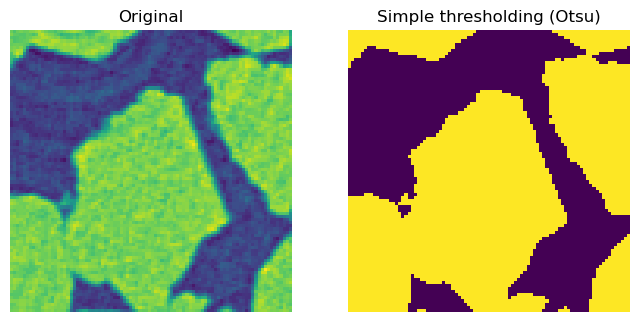

In [8]:
filename1 = "../data/Project211_sandstone_slice_0801hr.png"
img_hr = io.imread(filename1)
#img_hr = img_hr[:,:,0] #use only one channel of the three

# location and length of an image subset in x, y directions
locx = 470
lenx = 90
locy = 440
leny = 90

#use only one channel of the three and convert to unsigned character
img = img_as_ubyte(img_hr[locx:(locx+lenx),locy:(locy+leny),0])
#plt.imshow(img)
hist_stats(img)

## Simple thresholding
#find Otsu's threshold
thresh = threshold_otsu(img)
binary = img > thresh
binary  = img_as_ubyte(binary)

hist_stats(binary)

plot_comparison(img,'Original',binary,'Simple thresholding (Otsu)')

# SRM produces a comparable result, however it notably finds more regions which can helpful.
#seg = srm(img,Q=5)
#plot_comparison(img,'Original',seg,'SRM')


## Microscopy image of rice: uneven illumination problem

The image was downloaded from MATLAB (some time ago).

This example is the one with uneven illumination; as a result no thresholding works, no matter how fancy is the threshold 
finding method. It is a tif file, so it requires installation of 'tifffile' to read it in.

We will use skimage function that tries all implemented thresholds...simply to show that there is not one that works to get all rice grains segmented properly w/o issues with noise. This is where either smart filtering has to be done or the segmentation method has to be locally adapted.

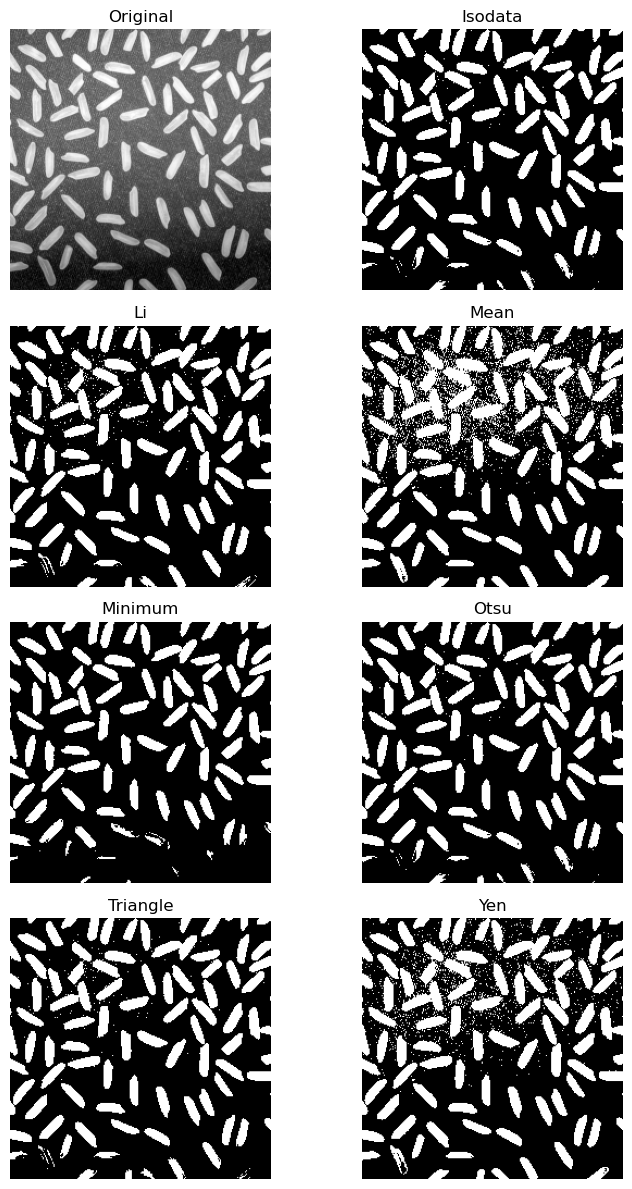

In [9]:
file  = "../data/rice_uneven_illumination.tif";
#filename = folder+"\\"+file;
filename = file

orig_img = tf.imread(filename)
img = img_as_ubyte(orig_img)

fig, ax = try_all_threshold(img, figsize = (8,12), verbose=False)
plt.show()

#### Attempt histogram equilization and local contrast equilization to fix the illumination problem.


10.000940571007776


()

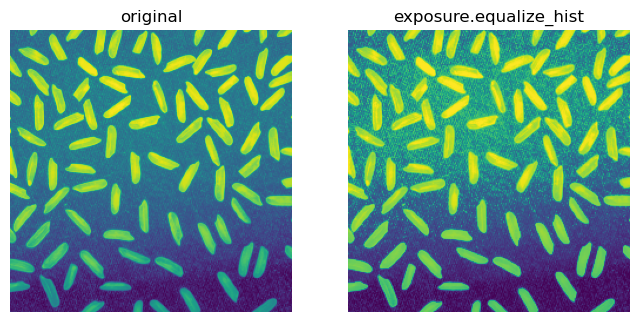

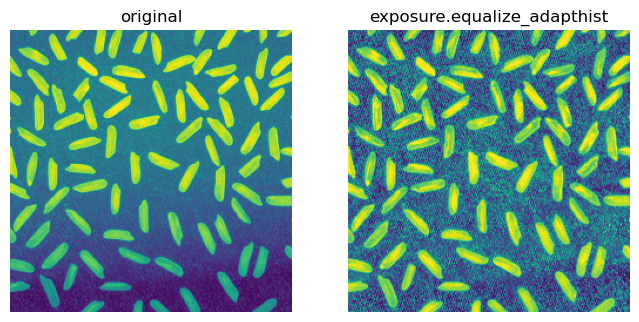

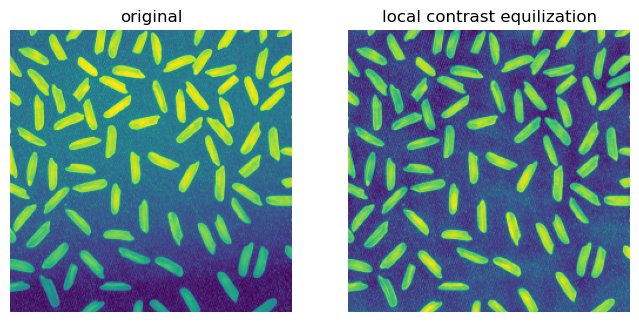

In [10]:
# Equalization
img_eq = exposure.equalize_hist(img)
#img_eq_med = sf.median(img_eq,sm.square(7))
plot_comparison(img, 'original', img_eq, 'exposure.equalize_hist')

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
plot_comparison(img, 'original',img_adapteq, 'exposure.equalize_adapthist')

# Local contrast normalization - my locally implemented method, see the code above
img_con = local_contrast_normalization(img,40, 1, 100, 0.000000001)
#img_con = global_contrast_normalization(img, 1, 100, 0.000000001)

plot_comparison(img, 'original', img_con, 'local contrast equilization')

####  It is obvious that manipulating image range / histogram can amplify some undesirable noise, so thread carefully. 
#### Local contrast normalization (which changes/rescales the entire image on a local level) is the winner for the illumination problem. It could possibly improve a bit by using a median filter, but for now we we take that image and segment it using simple thresholding (Otsu threshold).

()

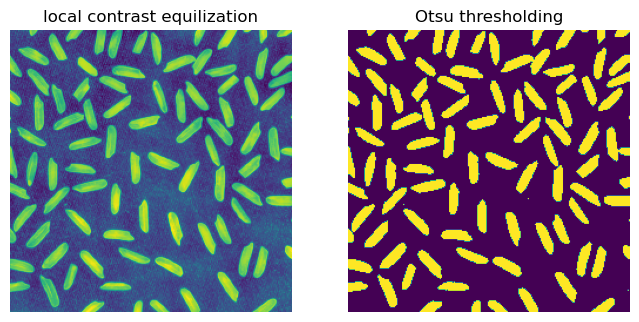

In [11]:
from skimage.filters import threshold_otsu

thresh = threshold_otsu(img_con)
binary = img_con > thresh
binary  = img_as_ubyte(binary)

plot_comparison(img_con,'local contrast equilization',binary,'Otsu thresholding')

## __Exercise/asssignment__: 
Check what do various histogram manipulations tested above do (or destroy...) for the sandstone (x-ray) image.

### More advanced filtering/segmentation method: statistical region merging (SRM)

In statistical region merging, you request a number of phases Q but you will get something close to it in the iterative
statistical region merging process. This can be viewed as a type of gray level filtering, of course, and Q decideds how aggressive do
you want it to be (the smaller the Q, more merging happens).

The fact that the result does not precisely have Q regions in the end is actually a good thing as many times we do not know how many phases we have in the image and should not prescribe it.

This SRM image is a filtered image where histogram should show where and how to threshold to get the result you need. 

Note that SRM actually provides a path to get the original image segmented right: for both results below, we can find a single threshold that
will separate rice grains from the background.

-----------------------------------
Image statistics:
	Shape: (240, 240)
	Data type: uint8
	Min: 0, Max:               223, Mean: 46.74388888888889

-----------------------------------
Image statistics:
	Shape: (240, 240)
	Data type: uint8
	Min: 53, Max:               241, Mean: 112.98366319444445



[{'shape': (240, 240),
  'dtype': dtype('uint8'),
  'min': 53,
  'max': 241,
  'mean': 112.98366319444445,
  'median': 103.0,
  'variance': 3757.7589865810073,
  'skewness': 0.0,
  'kurtosis': -1.2000366216525522}]

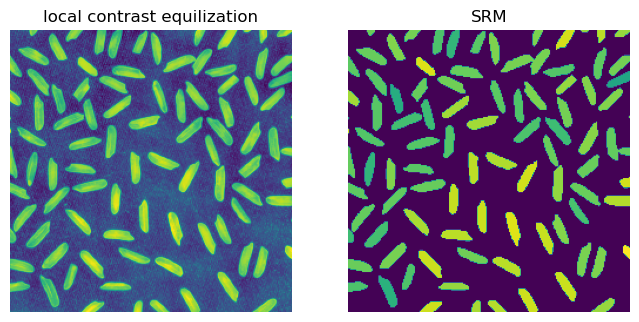

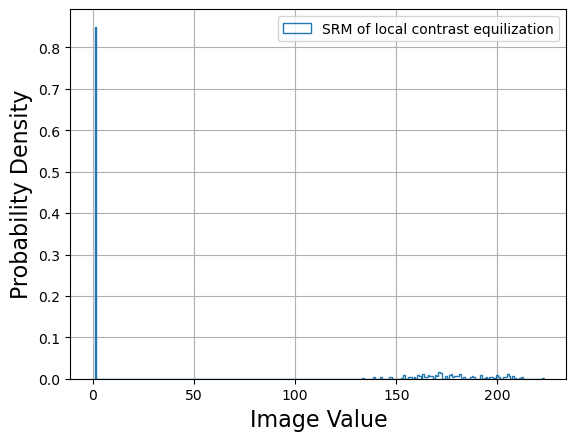

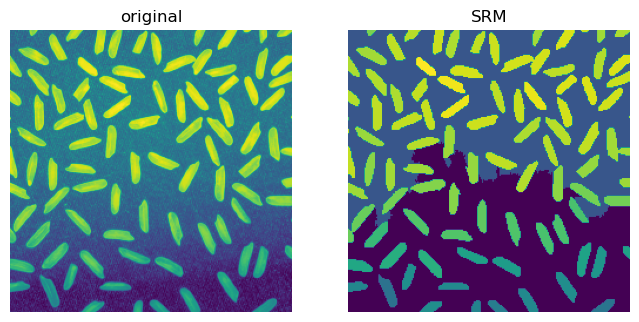

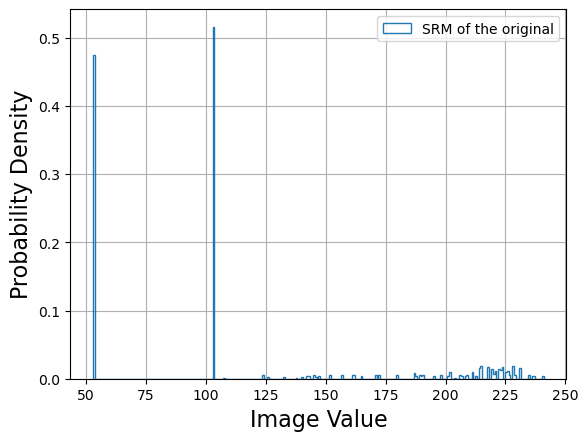

In [12]:
# Perform SRM on the corrected image
segmented = srm(img_as_ubyte(img_con), Q=5.0)
plot_comparison(img_con,'local contrast equilization',segmented,'SRM')
hist_stats(segmented,plot_histogram=True,legend_elem=['SRM of local contrast equilization'])

# Perform SRM on the original
segmentedo = srm(img_as_ubyte(img), Q=5)
plot_comparison(img,'original',segmentedo,'SRM')
hist_stats(segmentedo,plot_histogram=True,legend_elem=['SRM of the original'])

### Carbonate example (x-ray image)

Project 58 on Digital Rocks Portal, Estaillades carbonate #2 has a nice if complex CT of a carbonate sample we will use next.

We show two segmentations. One with very little filtering and using two thresholds (provided by multi-Otsu algorithm) and another where statistical region merging was applied aggresively and destroyed quite a bit of detail. None are suggested as ideal, and intended application would decide how to segment this image.

[ 98 141]
[ 59 104 137]
-----------------------------------
Image statistics:
	Shape: (300, 300)
	Data type: uint8
	Min: 44, Max:               227, Mean: 132.70942222222223

-----------------------------------
Image statistics:
	Shape: (300, 300)
	Data type: uint8
	Min: 23, Max:               247, Mean: 122.6962



()

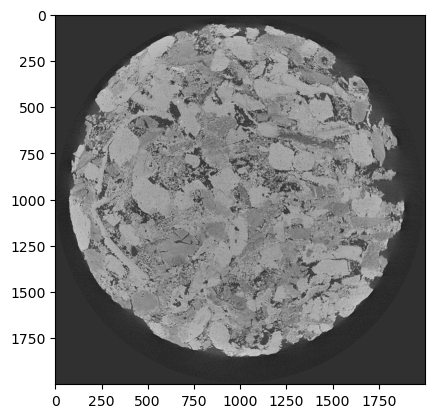

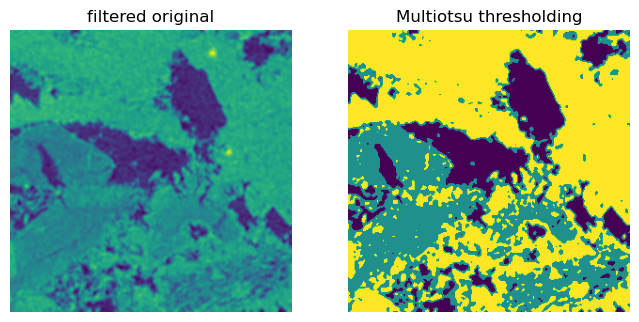

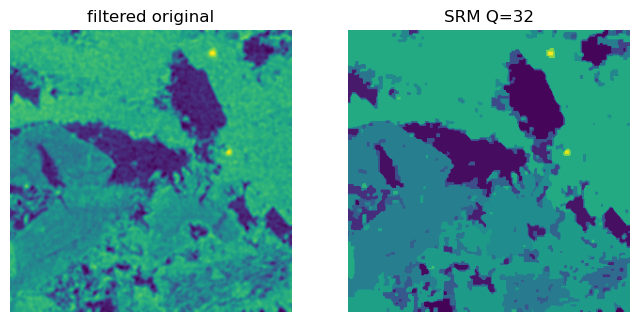

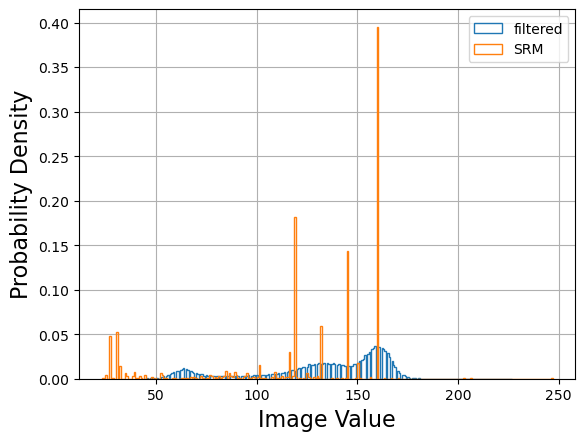

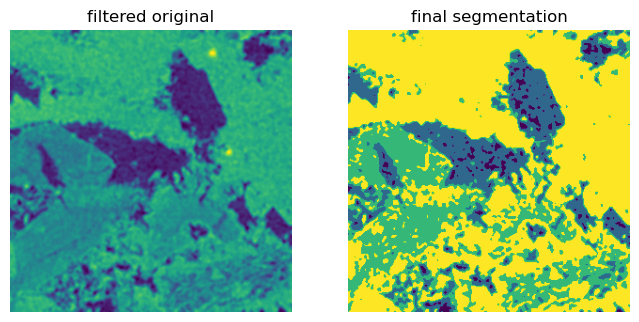

In [32]:
file_url = "https://www.digitalrocksportal.org/projects/58/images/68987/download/"
img_carbonate = io.imread(file_url)

#filename2 = "ES32_0135.tif" #if the file is downloaded
#img_carbonate = io.imread(filename2)
plt.imshow(img_carbonate,cmap='gray')

#Subsample and convert to uint8
N=300
img_csub = img_carbonate[450:450+N,450:450+N]
img_cmed = sf.median(img_csub,sm.square(3)) #median filter

# anisotropic diffusion
img_ani = anisotropic_diffusion(img_as_float(img_cmed),kappa=5000,niter=5,gamma=0.2,option=3)
#hist_stats(img_ani)
img_ani = img_as_ubyte(img_ani) # SRM expects integers

img_cmed = img_as_ubyte(img_cmed)  #convert to ubyte values

#pick which filtered image to use for the rest of the analysis
#img_filt = img_cmed
img_filt = img_ani



# from now on work with anisotropic diffusion
thresholds = threshold_multiotsu(img_filt) # SRM expects uint8, uint16 or uint32
img_simple_seg = np.digitize(img_filt,thresholds)
print(thresholds)
plot_comparison(img_filt,'filtered original',img_simple_seg,'Multiotsu thresholding')

img_srm  = srm(img_filt, Q=32)
plot_comparison(img_filt,'filtered original',img_srm,'SRM Q=32')

# Applying multi-Otsu threshold for the default value, for the final grouping in (three)
# classes. https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_multiotsu.html
# By default, the algorithm finds two thresholds (which can separate image into three regions)
thresholds = threshold_multiotsu(img_srm,4)
print(thresholds)

# I think order or the legend elements is reversed?
hist_stats(img_filt,img_srm,plot_histogram=True,legend_elem=['filtered','SRM'])

# Using the threshold values, we generate the three regions.
img_seg = np.digitize(img_filt, bins=thresholds)

plot_comparison(img_filt,'filtered original',img_seg,'final segmentation')

### Comments 

1. Segmented images should be further filtered, but this is a more advanced topic. Median filtering, and morphological operators are used to fix issues near boundaries of different regions.
   
2. All methods shown above work with 3D images
Thresholding is a rather trivial segmentation method so it works in 3D the same way as for 2D data. 
SRM wrapper available from Digital Porous Media shown here will recognize 3D data and adapt the underlying method.

